# Multi-Armed Bandit Problem: Strategies and Regret Analysis

This notebook demonstrates several algorithms to solve the multi-armed bandit problem using the `emails.csv` data file. Each row of the file corresponds to a customer and each column corresponds to a different email variant (arm). When an email is sent, only the outcome (success or failure) of the chosen email is observed. A success is marked by $1$ and a failure by $0$.

We assume a known best conversion rate, $BEST\_P = 0.213$, which is used to compute the regret for each algorithm. The regret at time $t$ is defined as:
$$
\text{Regret}(t) = BEST\_P \times t - \text{Cumulative Reward at time } t.
$$

## Overview of the Implemented Algorithms

The notebook implements the following strategies:

1. **Pure Exploration**:  
   Randomly selects an arm for every customer. No prior information is used.

2. **Pure Exploitation (with prior successes)**:  
   Initializes each arm with one success (i.e., assumes a success prior) and then always picks the arm with the highest empirical success rate.

3. **Explore-then-Exploit**:  
   Uses pure exploration for the first $T_0$ steps (here $T_0=100$), then switches to exploitation by choosing the arm with the highest empirical success rate.

4. **Epsilon-Greedy (with prior successes)**:  
   At each time step $t$, with probability $1/t$, an arm is selected at random (exploration); otherwise, the arm with the highest empirical success rate is selected (exploitation).  
   Each arm starts with one success.

5. **Upper Confidence Bound (UCB)**:  
   Starts with one success per arm. At each time step $t$, the arm selected is:
   $$
   \text{arm} = \arg\max_a \left\{ \hat{p}_a + \alpha \sqrt{\frac{\ln(t)}{\text{counts}[a]}} \right\}
   $$
   where $\hat{p}_a$ is the empirical success rate, and $\alpha$ is a tuning parameter (set to $0.75$).

6. **Thompson Sampling (Beta-Bernoulli)**:  
   Models each arm’s success probability with a Beta distribution, starting with a uniform prior, $Beta(1,1)$. At every step, a sample is drawn from each arm’s Beta distribution, and the arm with the highest sample is selected. The distribution is then updated based on the observed reward.

7. **Bootstrap**:  
   Maintains a list of observed rewards for each arm (initially $[1]$ to represent prior success). For each arm, a bootstrapped sample is drawn (with replacement) from its reward list to estimate the empirical success rate, and the arm with the highest estimated rate is selected.

## Plotting and Comparison

The notebook also produces:
- A plot comparing the cumulative regrets of all algorithms over time.
- Histograms showing the distribution of the chosen arms for the first $100$ and the last $100$ customers for UCB, Thompson Sampling, and Bootstrap.

These visualizations help to understand the exploration-exploitation trade-off and how each algorithm converges over time.

---

=== Pure Exploration ===
Final reward: 1649.00
Final regret: 481.00

=== Pure Exploitation (prior successes) ===
Final reward: 1987.00
Final regret: 143.00

=== Explore then Exploit (T0=100, prior successes) ===
Final reward: 2112.00
Final regret: 18.00

=== Epsilon-Greedy (epsilon = 1/t, prior successes) ===
Final reward: 1988.00
Final regret: 142.00

=== UCB (alpha=0.75, prior successes) ===
Final reward: 1999.00
Final regret: 131.00

=== Thompson Sampling (Beta-Bernoulli, uniform prior) ===
Final reward: 2062.00
Final regret: 68.00

=== Bootstrap (with prior successes) ===
Final reward: 2082.00
Final regret: 48.00


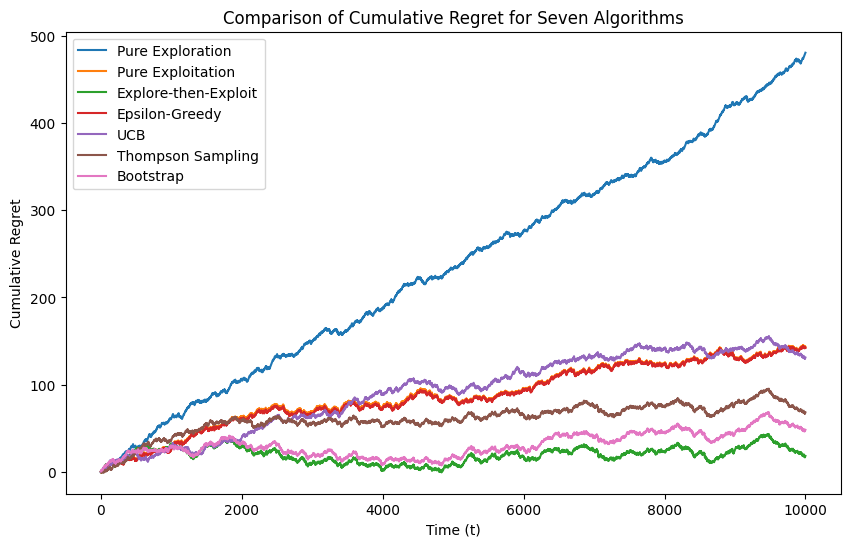

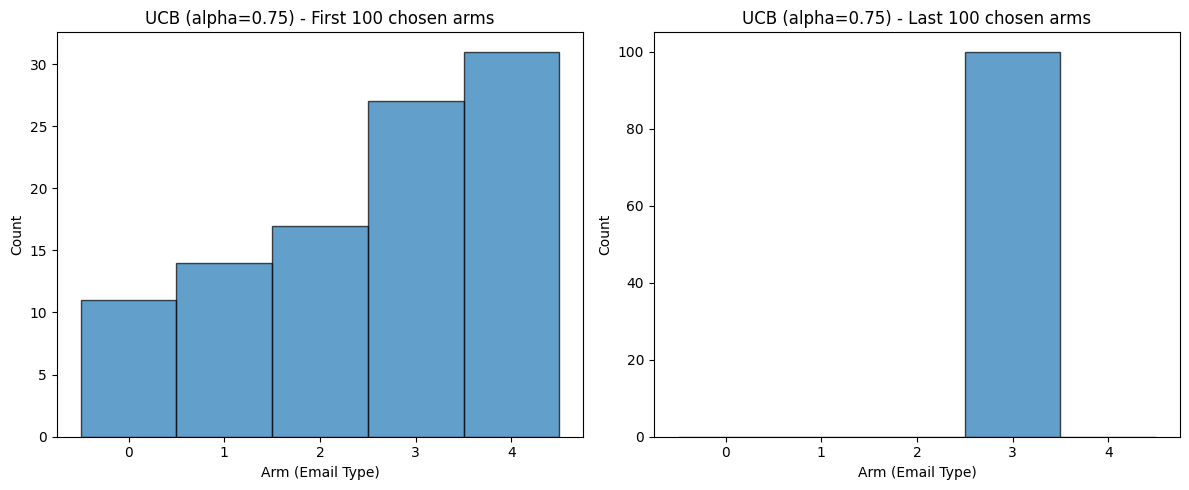

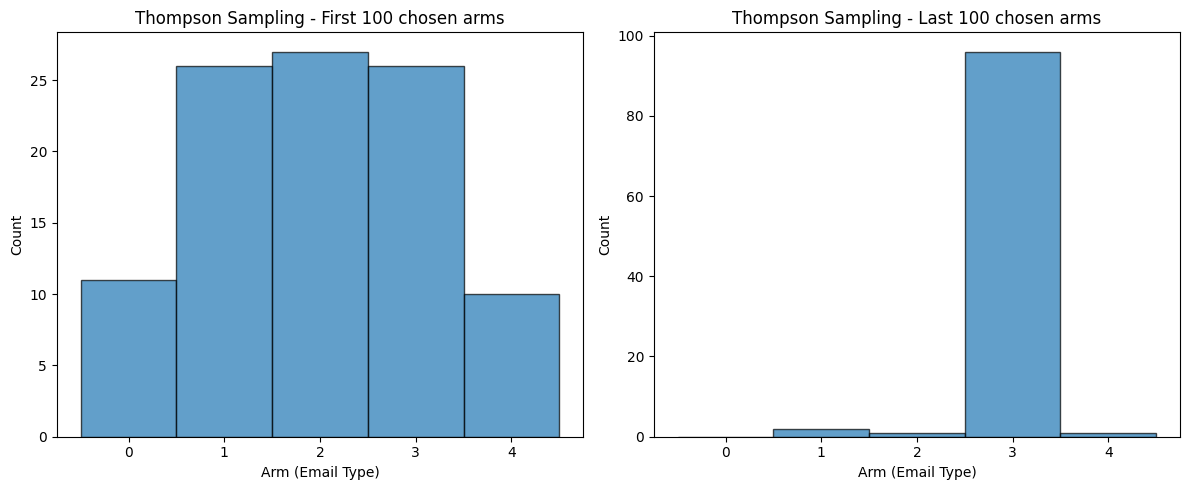

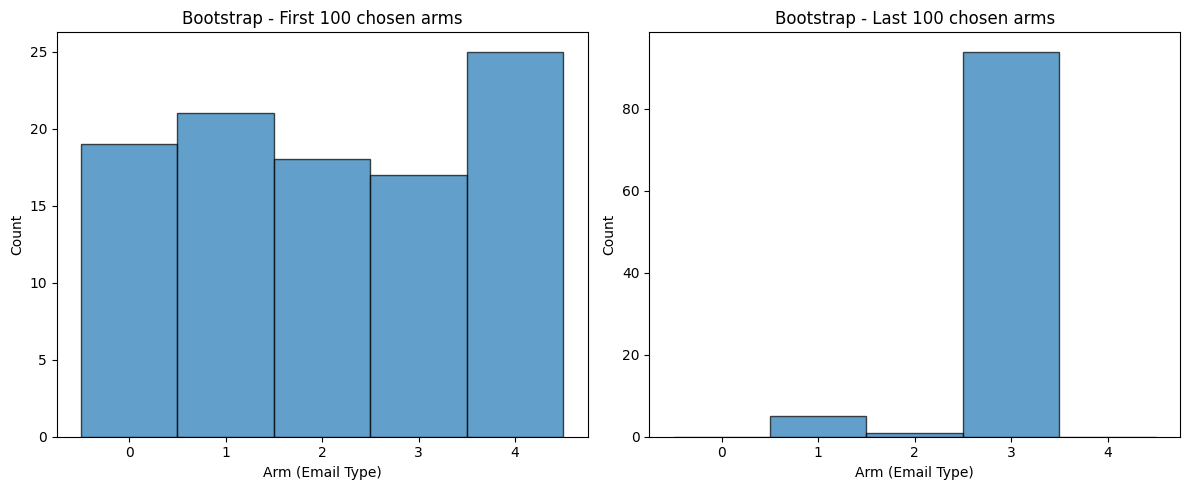

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BEST_P = 0.213  # Known best conversion rate from the problem

def pure_exploration_with_regret(data, T):
    """
    1) Pure Exploration
       Always pick an arm at random. No prior successes assumed.
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    for i in range(T):
        chosen_arm = np.random.choice(K)
        reward = data[i, chosen_arm]
        cumulative_reward += reward
        regrets[i] = BEST_P * (i + 1) - cumulative_reward
    
    return cumulative_reward, regrets

def pure_exploitation_with_regret(data, T):
    """
    2) Pure Exploitation (with prior successes)
       successes[a] = 1, counts[a] = 1 for each arm => p_hat[a] = 1 initially.
       Always pick the arm with the highest empirical success rate so far.
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    successes = np.ones(K, dtype=float)
    counts    = np.ones(K, dtype=int)
    
    for i in range(T):
        p_hat = successes / counts
        chosen_arm = np.argmax(p_hat)
        reward = data[i, chosen_arm]
        counts[chosen_arm] += 1
        successes[chosen_arm] += reward
        cumulative_reward += reward
        regrets[i] = BEST_P * (i + 1) - cumulative_reward
    
    return cumulative_reward, regrets

def explore_then_exploit_with_regret(data, T, T0=100):
    """
    3) Explore-then-Exploit (with prior successes)
       - First T0 steps: pick arms at random.
       - After T0: pick the arm with the highest empirical success rate.
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    successes = np.ones(K, dtype=float)
    counts    = np.ones(K, dtype=int)
    
    for i in range(T):
        if i < T0:
            chosen_arm = np.random.choice(K)
        else:
            p_hat = successes / counts
            chosen_arm = np.argmax(p_hat)
        
        reward = data[i, chosen_arm]
        counts[chosen_arm] += 1
        successes[chosen_arm] += reward
        cumulative_reward += reward
        regrets[i] = BEST_P * (i + 1) - cumulative_reward
    
    return cumulative_reward, regrets

def epsilon_greedy_with_regret_prior_successes(data, T):
    """
    4) Epsilon-Greedy (epsilon = 1/t), with prior successes
       - successes[a] = 1, counts[a] = 1 for each arm initially.
       - With probability 1/t, pick an arm at random (exploration).
         Otherwise pick the arm with highest p_hat (exploitation).
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    successes = np.ones(K, dtype=float)
    counts    = np.ones(K, dtype=int)
    
    for i in range(T):
        t = i + 1
        epsilon = 1.0 / t
        
        if np.random.rand() < epsilon:
            chosen_arm = np.random.choice(K)
        else:
            p_hat = successes / counts
            chosen_arm = np.argmax(p_hat)
        
        reward = data[i, chosen_arm]
        counts[chosen_arm] += 1
        successes[chosen_arm] += reward
        cumulative_reward += reward
        regrets[i] = BEST_P * t - cumulative_reward
    
    return cumulative_reward, regrets

def ucb_with_regret_prior_successes(data, T, alpha=0.75):
    """
    5) UCB (with prior successes)
       - successes[a] = 1, counts[a] = 1 for each arm initially => p_hat[a] = 1.
       - Choose arm a maximizing: p_hat[a] + alpha * sqrt(log(t) / counts[a]).
       - Also store chosen arms for histogram.
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    successes = np.ones(K, dtype=float)
    counts    = np.ones(K, dtype=int)
    
    # Store chosen arms
    chosen_arms = np.zeros(T, dtype=int)
    
    for i in range(T):
        t = i + 1
        p_hat = successes / counts
        bonus = alpha * np.sqrt(np.log(t) / counts)
        ucb_values = p_hat + bonus
        
        chosen_arm = np.argmax(ucb_values)
        chosen_arms[i] = chosen_arm
        
        reward = data[i, chosen_arm]
        counts[chosen_arm] += 1
        successes[chosen_arm] += reward
        cumulative_reward += reward
        
        regrets[i] = BEST_P * t - cumulative_reward
    
    return cumulative_reward, regrets, chosen_arms

def thompson_sampling_with_regret(data, T):
    """
    6) Thompson Sampling (Beta-Bernoulli), uniform prior
       - alpha[a] = 1, beta[a] = 1 for each arm => Beta(1,1).
       - Sample from Beta for each arm, pick the arm with highest sample.
       - Update alpha or beta based on observed reward.
       - Also store chosen arms for histogram.
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    alpha = np.ones(K, dtype=float)
    beta  = np.ones(K, dtype=float)
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    chosen_arms = np.zeros(T, dtype=int)
    
    for i in range(T):
        t = i + 1
        samples = np.array([np.random.beta(alpha[a], beta[a]) for a in range(K)])
        chosen_arm = np.argmax(samples)
        chosen_arms[i] = chosen_arm
        
        reward = data[i, chosen_arm]
        if reward == 1:
            alpha[chosen_arm] += 1
        else:
            beta[chosen_arm] += 1
        
        cumulative_reward += reward
        regrets[i] = BEST_P * t - cumulative_reward
    
    return cumulative_reward, regrets, chosen_arms

def bootstrap_with_regret_prior_successes(data, T):
    """
    7) Bootstrap (with prior successes)
       - For each arm, we keep a list of observed rewards, initially [1].
       - At time t, for each arm a:
         1) Draw a bootstrapped sample (with replacement) from that arm's reward list.
         2) Compute p_hat[a] = mean(bootstrapped sample).
       - Choose the arm with the highest p_hat[a].
       - Observe reward, add it to that arm's list.
       - Also store chosen arms for histogram.
    """
    total_rows, K = data.shape
    T = min(T, total_rows)
    
    arm_datasets = [[] for _ in range(K)]
    for a in range(K):
        arm_datasets[a].append(1.0)  # prior success
    
    cumulative_reward = 0.0
    regrets = np.zeros(T)
    
    chosen_arms = np.zeros(T, dtype=int)
    
    for i in range(T):
        t = i + 1
        
        p_hat = np.zeros(K)
        for a in range(K):
            dataset = arm_datasets[a]
            boot_sample = np.random.choice(dataset, size=len(dataset), replace=True)
            p_hat[a] = np.mean(boot_sample)
        
        chosen_arm = np.argmax(p_hat)
        chosen_arms[i] = chosen_arm
        
        reward = data[i, chosen_arm]
        arm_datasets[chosen_arm].append(reward)
        
        cumulative_reward += reward
        regrets[i] = BEST_P * t - cumulative_reward
    
    return cumulative_reward, regrets, chosen_arms

def plot_hist_of_chosen_arms(chosen_arms, K, algo_name):
    """
    Creates two histograms:
      - Distribution of chosen arms for the first 100 customers
      - Distribution of chosen arms for the last 100 customers
    """
    # First 100
    first_100 = chosen_arms[:100]
    # Last 100
    last_100 = chosen_arms[-100:]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(first_100, bins=np.arange(K + 1) - 0.5, edgecolor='black', alpha=0.7)
    plt.xticks(range(K))
    plt.xlabel("Arm (Email Type)")
    plt.ylabel("Count")
    plt.title(f"{algo_name} - First 100 chosen arms")
    
    plt.subplot(1, 2, 2)
    plt.hist(last_100, bins=np.arange(K + 1) - 0.5, edgecolor='black', alpha=0.7)
    plt.xticks(range(K))
    plt.xlabel("Arm (Email Type)")
    plt.ylabel("Count")
    plt.title(f"{algo_name} - Last 100 chosen arms")
    
    plt.tight_layout()
    plt.show()

def run_and_compare_algorithms(file_path, T=10000, random_seed=42):
    """
    Compare all seven algorithms:
      1) Pure Exploration
      2) Pure Exploitation (prior successes)
      3) Explore-then-Exploit (T0=100, prior successes)
      4) Epsilon-Greedy (1/t, prior successes)
      5) UCB (alpha=0.75, prior successes)
      6) Thompson Sampling (Beta(1,1))
      7) Bootstrap (with prior successes)
      
    Also plots:
      - final cumulative regret comparison,
      - histograms of chosen arms (first 100, last 100) for UCB, Thompson, Bootstrap.
    """
    # Reproducible results
    np.random.seed(random_seed)
    
    # Load data
    df = pd.read_csv(file_path, header=None)
    data = df.values
    
    # 1) Pure Exploration
    exploration_reward, regrets_explore = pure_exploration_with_regret(data, T)
    print("=== Pure Exploration ===")
    print(f"Final reward: {exploration_reward:.2f}")
    print(f"Final regret: {regrets_explore[-1]:.2f}")
    
    # 2) Pure Exploitation (prior successes)
    exploitation_reward, regrets_exploit = pure_exploitation_with_regret(data, T)
    print("\n=== Pure Exploitation (prior successes) ===")
    print(f"Final reward: {exploitation_reward:.2f}")
    print(f"Final regret: {regrets_exploit[-1]:.2f}")
    
    # 3) Explore-then-Exploit (T0=100, prior successes)
    ete_reward, regrets_ete = explore_then_exploit_with_regret(data, T, T0=100)
    print("\n=== Explore then Exploit (T0=100, prior successes) ===")
    print(f"Final reward: {ete_reward:.2f}")
    print(f"Final regret: {regrets_ete[-1]:.2f}")
    
    # 4) Epsilon-Greedy (1/t, prior successes)
    eg_reward, regrets_eg = epsilon_greedy_with_regret_prior_successes(data, T)
    print("\n=== Epsilon-Greedy (epsilon = 1/t, prior successes) ===")
    print(f"Final reward: {eg_reward:.2f}")
    print(f"Final regret: {regrets_eg[-1]:.2f}")
    
    # 5) UCB (alpha=0.75, prior successes)
    ucb_reward, regrets_ucb, chosen_arms_ucb = ucb_with_regret_prior_successes(data, T, alpha=0.75)
    print("\n=== UCB (alpha=0.75, prior successes) ===")
    print(f"Final reward: {ucb_reward:.2f}")
    print(f"Final regret: {regrets_ucb[-1]:.2f}")
    
    # 6) Thompson Sampling (Beta(1,1) for each arm, no prior successes)
    ts_reward, regrets_ts, chosen_arms_ts = thompson_sampling_with_regret(data, T)
    print("\n=== Thompson Sampling (Beta-Bernoulli, uniform prior) ===")
    print(f"Final reward: {ts_reward:.2f}")
    print(f"Final regret: {regrets_ts[-1]:.2f}")
    
    # 7) Bootstrap (with prior successes)
    boot_reward, regrets_boot, chosen_arms_boot = bootstrap_with_regret_prior_successes(data, T)
    print("\n=== Bootstrap (with prior successes) ===")
    print(f"Final reward: {boot_reward:.2f}")
    print(f"Final regret: {regrets_boot[-1]:.2f}")
    
    # Plot final cumulative regret comparison
    timesteps = np.arange(1, T + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, regrets_explore, label="Pure Exploration")
    plt.plot(timesteps, regrets_exploit, label="Pure Exploitation")
    plt.plot(timesteps, regrets_ete, label="Explore-then-Exploit")
    plt.plot(timesteps, regrets_eg, label="Epsilon-Greedy")
    plt.plot(timesteps, regrets_ucb, label="UCB")
    plt.plot(timesteps, regrets_ts, label="Thompson Sampling")
    plt.plot(timesteps, regrets_boot, label="Bootstrap")
    plt.xlabel("Time (t)")
    plt.ylabel("Cumulative Regret")
    plt.title("Comparison of Cumulative Regret for Seven Algorithms")
    plt.legend()
    plt.show()
    
    # Now create histograms for UCB, Thompson Sampling, and Bootstrap
    # (first 100 vs. last 100)
    K = data.shape[1]
    
    plot_hist_of_chosen_arms(chosen_arms_ucb, K, "UCB (alpha=0.75)")
    plot_hist_of_chosen_arms(chosen_arms_ts, K, "Thompson Sampling")
    plot_hist_of_chosen_arms(chosen_arms_boot, K, "Bootstrap")

if __name__ == "__main__":
    run_and_compare_algorithms("emails.csv", T=10000, random_seed=42)
